# Female representation in Bollywood hits: A crude analysis
From Wikipedia, I collected data about the top 10 Bollywood hits each year from 1947-2022. I used OpenAI's models to classify each movie as 'female-led' or not, and to assign genders to the cast and the movie director. All these help us paint the picture of female representation over the years, specifically among Bollywood hits. Read more about this data and how it was collected on the [Kaggle dataset page]("https://www.kaggle.com/datasets/vsat156383/bollywood-hits-from-1947-2022-from-wikipedia") that I created.  

## Measures of female representation in Bollywood
I am using three measures, all imperfect, to understand the representation of women in Bollywood hits. 

1. Whether or not a movie can generally be said to *'female-led'*, and is binary (1 if female-led, 0 if not). This is a fuzzy concept that is hard to define. To give an example, a movie where "boy falls in love with girl" is not 'female-led'. A movie where "girl goes on a journey to discover her true self" is female-led. Capturing this in the wide diversity of Indian movies using imperfect data is tough and inevitably this is a subjective, but not useless measure. 
2. *'female cast importance'* (normalized to lie between 0 and 1), and uses the scraped cast information. This measure is proportional to two things: the number of female actors listed in the cast, and also the *order* in which they're listed (listed earlier leads to a higher score). The exact definition can be seen in the code below. 
3. *female director*, i.e. whether the director of the movie is female (0 if male, 1 if female). 

## Qualitative findings
While each of these measures gives an incomplete picture, the combination of all three is more reliable and tells an interesting story. 
1. In the last ~15 years, there has been a mild uptick in all 3 measures, especially 'female director'. Depressingly, there's only one Bollywood movie which scores high on all 3 measures (i.e. has a 'female-led' plot, has a female director, and has a female cast importance > 0.6) - ["Panga"](https://en.wikipedia.org/wiki/Panga_(film)). 
2. Shockingly, in the entire dataset of 740 movies, only 10 of them have been directed by women. Not until Farah Khan's 2004 hit ["Main Hoon Na"](https://en.wikipedia.org/wiki/Main_Hoon_Na) was there a female directed Bollywood hit. 
3. Surprisingly, the first 5 years 1947-'52, score pretty well on both 'female-led' and 'female cast importance' metrics. An abundance of female stars - Suraiya, Nutan, Madhubala et. al. - who were likely just as popular as their male equivalents was possibly a factor here. 

<img src="chart.png" alt="Evolution of female representation in Bollywood, 1947-2022" width="400" height="300">

## Caveats and Limitations
1. Possibly the biggest limitation here is that I'm only looking at upto 10 hits from each year. Many critically successful or even reasonably popular movies do not make this list. For example, Kangana Ranaut's ["Queen"](https://en.wikipedia.org/wiki/Queen_(2013_film)) was reasonably successful, yet does not make the top 10 hits of the year. Another recent example is ["Pagglait"](https://en.wikipedia.org/wiki/Pagglait), which is also not in this dataset. My guess is that this limitation generally has the effect of making the situation look worse in terms of female representation, since female-led movies may not appeal to as broad an audience as the regular Bollywood fare. At the same time, limiting to just the hits perhaps gives us a better indication. 
    1. *Potential improvement*: Consider all movies, but weight them by their performance at the box-office. This requires updating the data collection scripts. 
2. Classifying a movie as 'female-led' in a consistent way, over 75 years of movies, is extremely hard. I have no idea whether we are correctly classifying the really old movies (e.g. ["Mirza Sahiban"](https://en.wikipedia.org/wiki/Mirza_Sahiban_(1947_film)) ), and I mostly did not override the AI's classifications in these cases. Among recent examples, the two Akshay Kumar starrers "Toilet" and "Pad-Man" are arguably not female-led, but I erred on the side of generosity here and let the AI's classification that they are female-led remain. 


# Imports

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math

# Load the data and manually override false positives

In [2]:
with open('hindi_hits_from_1947_to_2022_ai_enhanced.json', 'r') as f:
    lines = set(f.readlines())
movies = json.loads("[" + ",".join(lines) + "]")
print("Loaded {} movies".format(len(movies)))

Loaded 740 movies


In [3]:
# a given gender's score is proportional to two factors:
# 1) how many actors of that gender there are
# 2) how high up in the cast list they are
def female_cast_importance(cast):
    score = {'male': 0, 'female': 0}
    
    for i, actor in enumerate(cast):
        gender = actor['gender'].lower()
        if gender in ['male', 'female']:
            score[gender] += 1 / math.log(i+2)  # Higher weight for actors earlier in the list
        
    return score['female'] / (score['male'] + score['female'])

ex = female_cast_importance([{'gender': 'male'}, {'gender': 'male'}, {'gender': 'male'}, {'gender': 'female'}])
print("female-cast-importance if the cast is 'male, male, male, female' is {}".format(ex))

female-cast-importance if the cast is 'male, male, male, female' is 0.16812753627111746


In [4]:
rows = []
for movie in movies:
    if movie['title'] == "Roti":
        # this one's broken
        continue
    cast_string = ", ".join([x['name'] for x in movie['cast'][:4]])
    # put all of these into a pandas dataframe
    rows.append({
        'year': movie['year'],
        'title_link': '<a href="' + movie['movie_url'] + '">' + movie['title'] + '</a>',
        'title': movie['title'],
        'female-led': movie['female-led'],
        'female_cast_importance': female_cast_importance(movie['cast']),
        'female_director': movie['director']['gender'].lower() == "female",
        'director_name': movie['director']['name'],
        'actors': cast_string
    })
df = pd.DataFrame(rows)

In [5]:
# Manually override some movies that were incorrectly classified
female_led_false_positives = [
    "Mujhse Dosti Karoge!",
    "Pardes",
    "Anari",
    "Amrit",
    "Judaai",
    "Tum Haseen Main Jawan",
    "Sharafat",
    "Aya Sawan Jhoom Ke",
    "An Evening in Paris",
    "Phool Aur Patthar",
    "Guide",
    "Gehra Daag",
    "Dil Apna Aur Preet Parayi",
    "Phagun",
    "Phir Subah Hogi",
    "Jagriti",
    "Sangdil",
    "Jadoo",
    "Arzoo",
    "Saathiya",
    "Ready",
    "Goliyon Ki Raasleela Ram-Leela",
    "Badrinath Ki Dulhania"
]
df.loc[df['title'].isin(female_led_false_positives), 'female-led'] = False

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)

# List of movies considered 'female-led'

In [7]:
# female led, sort by year
subset = df[df["female-led"]==True].sort_values(by="year")
display(HTML(subset.to_html(index=False, escape=False)))

year,title_link,title,female-led,female_cast_importance,female_director,director_name,actors
1947,Neel Kamal,Neel Kamal,True,0.70,False,Kidar Sharma,"Begum Para, Raj Kapoor, Madhubala"
1947,Mirza Sahiban,Mirza Sahiban,True,0.61,False,K. Amarnath,"Nurjehan, Trilok Kapoor"
1949,Bari Behen,Bari Behen,True,0.49,False,D. D. Kashyap,"Suraiya, Rehman, Ullhas, Geeta Bali"
1949,Singaar,Singaar,True,0.77,False,J. K. Nanda,"Suraiya, Madhubala, Jairaj"
1950,Beqasoor,Beqasoor,True,0.39,False,K. Amarnath,"Madhubala, Ajit, Yakub, Gope"
1951,Hum Log,Hum Log,True,0.75,False,Zia Sarhadi,"Nutan, Balraj Sahni, Shyama, Durga Khote"
1952,Anhonee,Anhonee,True,0.39,False,K. A. Abbas,"Raj Kapoor, Nargis"
1953,Parineeta,Parineeta,True,0.39,False,Bimal Roy,"Ashok Kumar, Meena Kumari"
1957,Mother India,Mother India,True,0.39,False,Mehboob Khan,"Nargis, Sunil Dutt, Rajendra Kumar, Raaj Kumar"
1958,Sadhna,Sadhna,True,0.31,False,B.R. Chopra,"Sunil Dutt, Vyjayanthimala, Leela Chitnis, Radhakrishan"


# List of movies with female directors

In [8]:
subset = df[df["female_director"]][["year", "title_link", "director_name", "actors", "female-led", "female_cast_importance"]]
display(HTML(subset.to_html(escape=False)))

,year,title_link,director_name,actors,female-led,female_cast_importance
180,2010,Tees Maar Khan,Farah Khan,"Akshay Kumar, Akshaye Khanna, Katrina Kaif",False,0.23
225,2007,Om Shanti Om,Farah Khan,"Shah Rukh Khan, Deepika Padukone, Shreyas Talpade, Kirron Kher",False,0.36
267,2014,Happy New Year,Farah Khan,"Deepika Padukone, Shah Rukh Khan, Abhishek Bachchan, Sonu Sood",False,0.27
289,2019,Gully Boy,Zoya Akhtar,"Ranveer Singh, Alia Bhatt, Siddhant Chaturvedi",False,0.30
320,2011,Zindagi Na Milegi Dobara,Zoya Akhtar,"Hrithik Roshan, Abhay Deol, Farhan Akhtar, Katrina Kaif",False,0.28
347,2020,Chhapaak,Meghna Gulzar,"Deepika Padukone, Vikrant Massey",True,0.61
483,2004,Main Hoon Na,Farah Khan,"Shah Rukh Khan, Sushmita Sen, Sunil Shetty, Amrita Rao",False,0.36
552,2020,Panga,Ashwiny Iyer Tiwari,"Kangana Ranaut, Jassi Gill, Yagya Bhasin, Richa Chadda",True,0.62
596,2015,Dil Dhadakne Do,Zoya Akhtar,"Anil Kapoor, Shefali Shah, Priyanka Chopra, Ranveer Singh",False,0.46
641,2012,Talaash: The Answer Lies Within,Reema Kagti,"Aamir Khan, Kareena Kapoor, Rani Mukerji, Nawazuddin Siddiqui",False,0.45


# List of movies with female_cast_importance > 0.6

In [9]:
subset = df[df["female_cast_importance"] >= 0.6]
# Select specific columns
subset = subset[["year", "title_link", "director_name", "actors", "female_cast_importance"]]
subset = subset.sort_values(by="female_cast_importance", ascending=False)
display(HTML(subset.to_html(escape=False)))

,year,title_link,director_name,actors,female_cast_importance
737,2020,Thappad,Anubhav Sinha,Taapsee Pannu,1.00
659,2018,Hichki,Siddharth P. Malhotra,Rani Mukerji,1.00
704,1947,Dard,Abdul Rashid Kardar,"Munawwar Sultana, Suraiya, Nusrat, Husn Banu",0.80
575,1949,Singaar,J. K. Nanda,"Suraiya, Madhubala, Jairaj",0.77
735,1951,Hum Log,Zia Sarhadi,"Nutan, Balraj Sahni, Shyama, Durga Khote",0.75
317,2001,Lajja,Rajkumar Santoshi,"Manisha Koirala, Rekha, Madhuri Dixit, Mahima Chaudhry",0.70
220,2000,Fiza,Khalid Mohammed,"Karisma Kapoor, Hrithik Roshan, Jaya Bachchan",0.70
671,1947,Neel Kamal,Kidar Sharma,"Begum Para, Raj Kapoor, Madhubala",0.70
528,2022,Bhool Bhulaiyaa 2,Anees Bazmee,"Tabu, Kartik Aaryan, Kiara Advani",0.70
625,1960,Barsaat Ki Raat,P. L. Santoshi,"Madhubala, Bharat Bhushan, Shyama",0.70


# Plotting all three measures together, over time. 

In [10]:
#import os
#os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
#plt.style.use(['science'])
#plt.style.use('default')



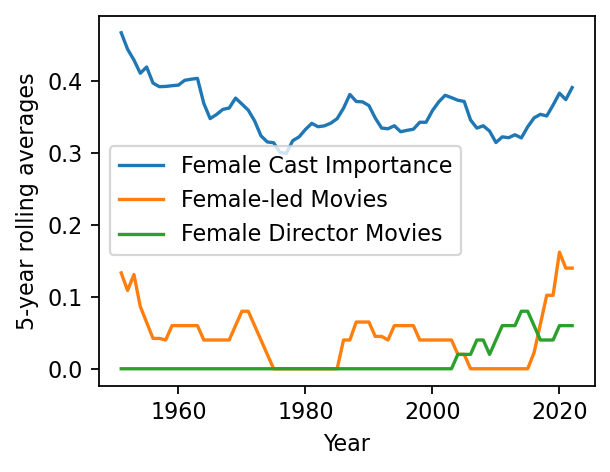

In [11]:
cast_importance = df.groupby('year')['female_cast_importance'].mean().rolling(window=5).mean()
female_led = df.groupby('year')['female-led'].mean().rolling(window=5).mean()
female_director = df.groupby('year')['female_director'].mean().rolling(window=5).mean()

desired_dpi = 160
fig_width, fig_height = 4, 3

plt.figure(figsize=(fig_width, fig_height), dpi=desired_dpi)
# Plot each series
plt.plot(cast_importance, label='Female Cast Importance')
plt.plot(female_led, label='Female-led Movies')
plt.plot(female_director, label='Female Director Movies')

# Set plot title and labels
#plt.title('Evolution of Female Representation in Movies')
plt.xlabel('Year')
plt.ylabel('5-year rolling averages')

# Show the legend
plt.legend()

# Display the plot
plt.show()
